# Creation of our own model

In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np

import cv2
torch.manual_seed(2)

# https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data

In [2]:
# Global variables

NEW_X = 338
NEW_Y = 190

In [3]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [4]:
# Create the model class using sigmoid as the activation function

class CarRecognitionNet(nn.Module):
    def __init__(self, in_size):
        super(CarRecognitionNet, self).__init__()
        # self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_size, 128)  # Modifiez selon la taille de votre image
        self.fc2 = nn.Linear(128, 4)  # 4 pour les coordonnées (x_min, y_min, x_max, y_max)

    def forward(self, x):
        #x = torch.relu(self.conv1(x))
        #x = torch.max_pool2d(x, kernel_size=2)
        #x = torch.relu(self.conv2(x))
        #x = torch.max_pool2d(x, kernel_size=2)
        print("x.size CRN forward : [", end="")
        print(x.size(0), end = ", ") # 3
        print(x.size(1), end = "] \n") # 128
        x = x.view(x.size(0), -1)  # Aplatir // x.size(0) pour garder le batch size flexible
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Prédictions des coordonnées
        return x
    

# train function, x.shape  = torch.Size([32, 3, 128, 128])
# x.size CRN forward : [32, 49152] 
# mat1 and mat2 shapes cannot be multiplied (49152x32 and 49152x128)

In [5]:
# Train the model

def train(model, criterion, train_loader, test_loader, optimizer, epochs=10):
    i = 0
    output = {'training_loss': [], 'test_accuracy': []}  
    
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            x=x.float()
            y=y.float()
            optimizer.zero_grad()
            print("train function, x.shape  = ", end="")
            print(x.shape)
            z = model(x.view(-1, NEW_X * NEW_Y * 3))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            output['training_loss'].append(loss.data.item())
        
        # correct = 0
        # for x, y in test_loader:
        #     z = model(x.view(-1, 128 * 128 * 3))
        #     _, label = torch.max(z, 1)
        #     print(z)
        #     correct += (label == y).sum().item()
    
        # accuracy = 100 * (correct / len(test_loader))
        # output['test_accuracy'].append(accuracy)
    
    return output

In [6]:
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torchvision.transforms as transforms
from skimage import io
import pandas as pd


class CarRecognitionDataset(Dataset):
    def __init__(self, images_dir, csv_annotations, transform=None):
        self.images_dir = images_dir
        self.annotations = pd.read_csv(csv_annotations)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.images_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        image = image[:,:,:3] # removing alpha cannal if it exists
        image_resized = cv2.resize(image, (NEW_X, NEW_Y))
        image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float() # readapte les canaux par permute
        
        y = torch.tensor(self.annotations.iloc[index, 1:5]) # 1:5 for bounding box coord
        y = y/2 # change to ratio
        # print(self.annotations.iloc[index, 0])
        # print(y)

        if self.transform:
            image_transformed = self.transform(image_resized)
            return image_transformed, y

        return image_tensor, y

        
        



In [7]:
dataset = CarRecognitionDataset(csv_annotations='data/train_boxes.csv', images_dir='data/train/',
                                 transform = transforms.ToTensor())

In [8]:
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, drop_last=True)

In [9]:
import torch.optim as optim

# images INITIAL shape : 676 x 380

learning_rate = 0.001
epochs = 10
model = CarRecognitionNet(NEW_X*NEW_Y*3) # image size et 3 canaux RGB

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

output=train(model, criterion, train_loader, val_loader, optimizer, epochs)




train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [32, 192660] 
train function, x.shape  = torch.Size([32, 3, 190, 338])
x.size CRN forward : [3

In [10]:
model.eval()
for name, param in model.named_parameters():
    param.requires_grad = False
print("done")

image_path = 'data/test/vid_5_400.jpg'
image = Image.open(image_path)


transform = transforms.Compose([transforms.Resize((NEW_X,NEW_Y)),
                                transforms.ToTensor()])
img = transform(image)
img = img.unsqueeze(0) # simuler un batch size de 1 pour avoir la bonne dim

pred = model(img)

done
x.size CRN forward : [1, 3] 


In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def afficher_bounding_boxes(image, pred):
    """
    Affiche l'image avec les bounding boxes.

    Parameters:
    - image: l'image à afficher (par exemple sous forme de tableau NumPy)
    - pred: liste des bounding boxes prédictes, chacune étant sous la forme (x_min, y_min, x_max, y_max)

    """
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Parcours des bounding boxes prédites
    for box in [pred.squeeze(0).tolist()]:
        x_min, y_min, x_max, y_max = box
        
        # Calcul de la largeur et de la hauteur du rectangle
        width = x_max - x_min
        height = y_max - y_min
        
        # Ajout du rectangle correspondant à la bounding box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.show()

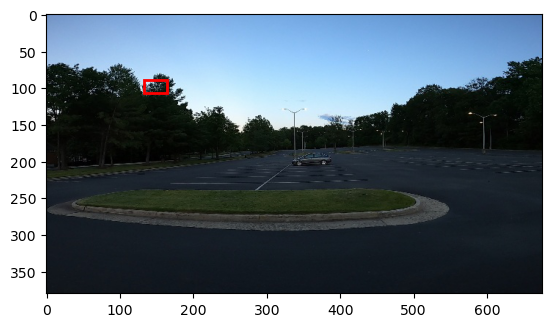

In [12]:
afficher_bounding_boxes(image, pred)

In [13]:
print(model)



CarRecognitionNet(
  (fc1): Linear(in_features=192660, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


In [14]:
output

{'training_loss': [19551.330078125,
  10755.3212890625,
  6088.9345703125,
  12013.9443359375,
  8382.2314453125,
  5827.7626953125,
  6778.8974609375,
  5054.59521484375,
  7428.36865234375,
  11070.09375,
  5968.60400390625,
  6961.4775390625,
  6038.46435546875,
  5153.20361328125,
  7184.66064453125,
  6554.44775390625,
  7663.66650390625,
  6081.09814453125,
  6199.810546875,
  5152.98388671875,
  5755.2568359375,
  6810.70703125,
  9574.748046875,
  4680.775390625,
  7910.27294921875,
  5017.056640625,
  5055.80859375,
  4370.45068359375,
  5356.07421875,
  6993.0341796875,
  7859.38623046875,
  5533.8916015625,
  5556.263671875,
  6022.18212890625,
  4571.21826171875,
  5832.5947265625,
  5921.48388671875,
  6982.21142578125,
  6162.11962890625,
  6121.01416015625,
  5466.173828125,
  4613.767578125,
  3878.85888671875,
  5849.7060546875,
  5067.2421875,
  4605.18212890625,
  5412.26611328125,
  5781.01123046875,
  4317.244140625,
  4742.564453125,
  3861.42529296875,
  4656.895